# ML100Marathon Final Exam
- [機器學習百日馬拉松期末考 - 花朵辨識](https://www.kaggle.com/competitions/2021-ml-100-marathon-final-exam)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step1 定義問題：圖像辨識，使用深度學習  

## Step2 確認資料集並檢視

In [2]:
import os
train_path = "/content/drive/MyDrive/image_data/train/"
test_path = "/content/drive/MyDrive/image_data/test/"
print(os.listdir(train_path))

# 花朵名稱對應的類別碼
flower_mapping = {"daisy":0, "dandelion":1, "rose":2, "sunflower":3, "tulip":4}
flowers = ["daisy", "dandelion", "rose", "sunflower", "tulip"]

['dandelion', 'daisy', 'rose', 'tulip', 'sunflower']


In [3]:
# 透過 data augmentation 產生訓練與驗證用的影像資料
# 參考資料: ImageDataGenerator: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# 參考資料: 【深度學習】ImageDataGenerator的使用: https://www.796t.com/content/1546542668.html
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=10, #隨機旋轉角度的上限 (角度值 : 0 ~ 180)
                  width_shift_range=0.2, # 左右隨機平移上限
                  height_shift_range=0.2, # 上下隨機平移上限
                  shear_range=0.2, # 逆時針的剪切變形角度
                  zoom_range=0.2, # 影像倍率放大縮小的上限
                  horizontal_flip=True, # 是否左右翻轉
                  fill_mode="nearest", # 填補周圍空缺方法
                  validation_split=0.2) # 測試集採樣比

In [4]:
IMAGE_SIZE = (240, 320)
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(train_path, # 目標目錄
                           target_size=IMAGE_SIZE, # 所有影象調整為IMAGE_SIZE
                           classes=flowers, 
                           batch_size=BATCH_SIZE, 
                           subset="training") # 設為訓練集

valid_generator = train_datagen.flow_from_directory(train_path, 
                           target_size=IMAGE_SIZE, 
                           classes=flowers, 
                           batch_size=BATCH_SIZE, 
                           subset="validation") # 設為驗證集  

Found 2260 images belonging to 5 classes.
Found 563 images belonging to 5 classes.


## Step3 建立模型

### 以 ResNet50 為基礎來建立模型(遷移學習)
### Model 1: With fixed learning rate

In [5]:
import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# 以 ResNet50 為基礎來建立模型(遷移學習)
# 參考資料: ResNet: https://zhuanlan.zhihu.com/p/31502877
resnet = ResNet50(input_shape=(240, 320, 3), weights="imagenet", pooling='avg', include_top=False)
# 增加 Dense Layer , 設定此模型5種分類的output , 並以 softmax 產生各類別的機率值
output = keras.layers.Dense(5, activation="softmax")(resnet.output)
model = Model(inputs=[resnet.input], outputs=[output])

model.summary()
    
# 使用 Adam optimizer, 使用固定的 learning rate 
model.compile(loss="categorical_crossentropy",
       optimizer=Adam(lr=1e-5),
       metrics=["accuracy"])

94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 246, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 120, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [6]:
early_stopping_1 = EarlyStopping(monitor="val_accuracy", patience=20)
model_checkpoint_1 = ModelCheckpoint("best_model_1.h5", monitor="val_accuracy", save_best_only=True)

In [7]:
# 訓練模型
# 參考資料: fit_generator: https://blog.csdn.net/dou3516/article/details/118757164
model.fit_generator(train_generator, 
          steps_per_epoch=train_generator.samples // BATCH_SIZE,
          epochs=100,
          validation_data=valid_generator, 
          validation_steps=valid_generator.samples // BATCH_SIZE,
          use_multiprocessing=True,
          workers=8,
          verbose=1,
          callbacks=[early_stopping_1, model_checkpoint_1])

Epoch 1/100
70/70 [==============================] - 214s 3s/step - loss: 1.2438 - accuracy: 0.4955 - val_loss: 0.6999 - val_accuracy: 0.7426
Epoch 2/100
70/70 [==============================] - 60s 765ms/step - loss: 0.5785 - accuracy: 0.8151 - val_loss: 0.3974 - val_accuracy: 0.8732
Epoch 3/100
70/70 [==============================] - 62s 816ms/step - loss: 0.3930 - accuracy: 0.8775 - val_loss: 0.3351 - val_accuracy: 0.8787
Epoch 4/100
70/70 [==============================] - 59s 776ms/step - loss: 0.2969 - accuracy: 0.9080 - val_loss: 0.2878 - val_accuracy: 0.9099
Epoch 5/100
70/70 [==============================] - 59s 774ms/step - loss: 0.2230 - accuracy: 0.9300 - val_loss: 0.2714 - val_accuracy: 0.9118
Epoch 6/100
70/70 [==============================] - 57s 728ms/step - loss: 0.1937 - accuracy: 0.9399 - val_loss: 0.2576 - val_accuracy: 0.9118
Epoch 7/100
70/70 [==============================] - 58s 764ms/step - loss: 0.1563 - accuracy: 0.9551 - val_loss: 0.2546 - val_accuracy: 0

In [8]:
# Collect results
results = {}
results["Fixed LR"] = {'train-loss': model.history.history["loss"],
             'valid-loss': model.history.history["val_loss"],
             'train-acc': model.history.history["accuracy"],
             'valid-acc': model.history.history["val_accuracy"]}

### Model 2: With reduced learning rate

In [9]:
from keras.callbacks import ReduceLROnPlateau

resnet_2 = ResNet50(input_shape=(240, 320, 3), weights="imagenet", pooling='avg', include_top=False)
# 增加 Dense Layer , 設定此模型5種分類的output , 並以 softmax 產生各類別的機率值
output_2 = keras.layers.Dense(5, activation="softmax")(resnet_2.output)
model_2 = Model(inputs=[resnet_2.input], outputs=[output_2])
    
# 使用 Adam optimizer, 使用較低的 learning rate 
model_2.compile(loss="categorical_crossentropy",
        optimizer=Adam(lr=1e-5),
        metrics=["accuracy"])

reduce_lr = ReduceLROnPlateau(factor=0.5, min_lr=1e-12, monitor='val_accuracy', patience=5, verbose=1)
early_stopping_2 = EarlyStopping(monitor="val_accuracy", patience=20)
model_checkpoint_2 = ModelCheckpoint("best_model_2.h5", monitor="val_accuracy", save_best_only=True)

model_2.fit_generator(train_generator, 
          steps_per_epoch=train_generator.samples // BATCH_SIZE,
          epochs=100,
          validation_data=valid_generator, 
          validation_steps=valid_generator.samples // BATCH_SIZE,
          use_multiprocessing=True,
          workers=8,
          verbose=1,
          callbacks=[reduce_lr, early_stopping_2, model_checkpoint_2])

Epoch 1/100
70/70 [==============================] - 66s 784ms/step - loss: 1.2573 - accuracy: 0.5108 - val_loss: 0.7116 - val_accuracy: 0.7482 - lr: 1.0000e-05
Epoch 2/100
70/70 [==============================] - 58s 739ms/step - loss: 0.5802 - accuracy: 0.8142 - val_loss: 0.3765 - val_accuracy: 0.8676 - lr: 1.0000e-05
Epoch 3/100
70/70 [==============================] - 58s 734ms/step - loss: 0.3903 - accuracy: 0.8757 - val_loss: 0.2750 - val_accuracy: 0.9136 - lr: 1.0000e-05
Epoch 4/100
70/70 [==============================] - 58s 747ms/step - loss: 0.2957 - accuracy: 0.9125 - val_loss: 0.2495 - val_accuracy: 0.9136 - lr: 1.0000e-05
Epoch 5/100
70/70 [==============================] - 67s 895ms/step - loss: 0.2369 - accuracy: 0.9300 - val_loss: 0.2112 - val_accuracy: 0.9246 - lr: 1.0000e-05
Epoch 6/100
70/70 [==============================] - 58s 747ms/step - loss: 0.1927 - accuracy: 0.9425 - val_loss: 0.2015 - val_accuracy: 0.9375 - lr: 1.0000e-05
Epoch 7/100
70/70 [===============

In [10]:
results["Reduced LR"] = {'train-loss': model_2.history.history["loss"],
              'valid-loss': model_2.history.history["val_loss"],
              'train-acc': model_2.history.history["accuracy"],
              'valid-acc': model_2.history.history["val_accuracy"]}

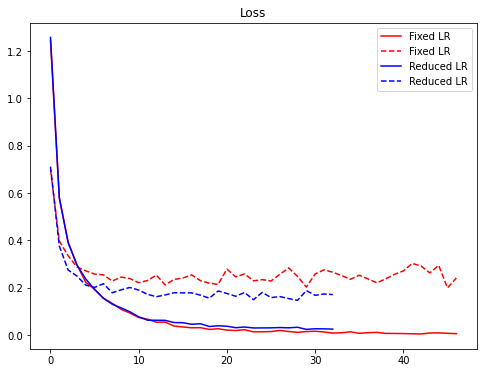

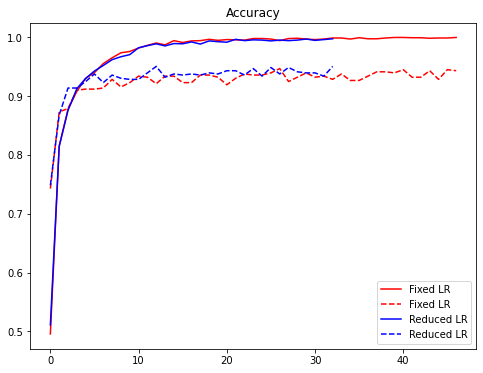

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "b"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

### 模型評估筆記
- 使用```ReduceLROnPlateau```根據validation accuracy來降低learning rate, validation loss比較低, 但accuracy差異不大
- 選擇```Model 2: With reduced learning rate```來做對測試圖做預測

In [12]:
from keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import pandas as pd
from tqdm import tqdm # 進度條顯示套件 

best_model = load_model("/content/best_model_2.h5")

# 設定最後的輸出資料
X_test = list()
id_test = []

# 使用 Keras 內建的載入寫法 
def load_image(img_path):
  img = load_img(img_path, target_size=(240, 320))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  return img 
def make_test_data():
    global X_test
    dir_path = test_path
    for img in tqdm(os.listdir(dir_path)):
        id_test.append(img[:-4])
        path = os.path.join(dir_path, img)
        img = load_image(path)
        img = np.squeeze(img, axis=0)
        X_test.append(np.array(img))
make_test_data()        
X_test = np.array(X_test)

# 輸出預測檔
pred = best_model.predict(X_test)
pred_digits = np.argmax(pred, axis=1)
sub = pd.DataFrame({"id": id_test, "flower_class": pred_digits})
sub.to_csv("flower_CNN_ver03.csv", index = False)

100%|██████████| 2000/2000 [00:35<00:00, 56.92it/s] 


63/63 [==============================] - 11s 154ms/step


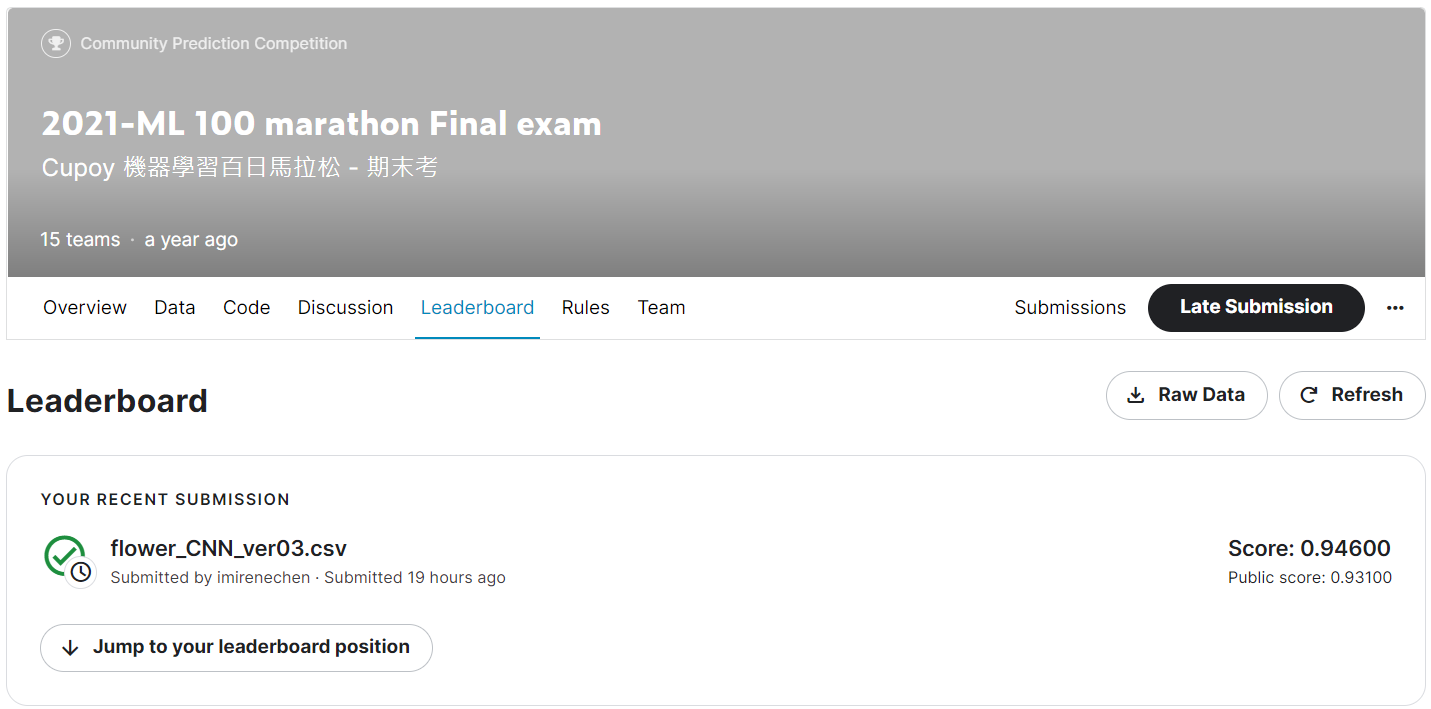